In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
import os, glob
from matplotlib.colors import ListedColormap

##### Load RF model

In [3]:
RF_score = 'gini'
yr_start = 2019
yr_end = 2021
mask = 'SIMPLE_MASK'
stand_str = 'STANDARDIZED'
RI_thresh = 30
weights = 'default'
N_samples_RF = 10
scoring = 'f1_weighted'
RF_dir = 'DATA/ML_model_results/TESTING/all_models_ROS_and_SMOTE/'
#RF_dir = '~/SHIPS/SHIPS_clean/Model_Results/VALIDATION/'
RF_ext = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=yr_start,yr_end=yr_end,mask_TYPE=mask,
            stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,scoring=scoring)
y_pred_RF = pd.read_csv(RF_dir+'PREDICTED_Y_vals'+RF_ext)
# y_pred_RF = y_pred_RF.rename(columns={'I_class':'Y true'})
#y_pred_RF#.groupby(['Predicted Basin','Model',pd.to_datetime(y_pred_RF['DATE_full']).dt.year])['Y pred'].count()

In [4]:
y_pred_RF.groupby(['Predicted Basin','Y true','Model']).count().xs(('Random Forest (random oversample)'),level=2).drop('ALL').sum(level=1)

,ATCFID,CASE,NAME,DATE_full,I_class,I_class label,Y pred,Y pred probab (class: 0),Y pred probab (class: 1)
Y true,,,,,,,,,
0.0,2215,2215,2215,2215,2215,2215,2215,2215,2215
1.0,330,330,330,330,330,330,330,330,330


In [5]:
y_pred_res = y_pred_RF.copy()
y_pred_res['Y pred probab (class: 1)'] = y_pred_res['Y pred probab (class: 1)']*100
y_pred_res['Prob. RI'] = (y_pred_res['Y pred probab (class: 1)']).round(-1)
y_pred_res['Prob. RI'] = y_pred_res['Prob. RI'].mask(y_pred_res['Prob. RI'] <= 5, 5)
#

basin_sel = ['ATLANTIC','EAST_PACIFIC','SOUTHERN_HEM','WEST_PACIFIC']

In [6]:
# rf_model_sel = 'Random Forest (random oversample)'
# y_trim = y_pred_res[y_pred_res['Model']==rf_model_sel]
y_trim = y_pred_res[y_pred_res['Predicted Basin'].isin(basin_sel)]
y_trim['YEAR'] = pd.to_datetime(y_trim['DATE_full']).dt.year

/tmp/ipykernel_176508/2325436153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_trim['YEAR'] = pd.to_datetime(y_trim['DATE_full']).dt.year


In [7]:
pct_range = y_trim['Prob. RI'].unique().tolist()
reliability = pd.DataFrame()
for imodel in y_trim['Model'].unique():
    for ipct in pct_range:
        # ipct = 10
        if ipct == 100:
            continue
        y_sel = y_trim.set_index(['Prob. RI','Model']).xs((ipct,imodel))
        total = y_sel.groupby(['Predicted Basin']).count()
        RI = y_sel[y_sel['Y true']==1].groupby(['Predicted Basin']).count()
        i_df = pd.DataFrame(index=total.index,columns={'Observed Pct','Predicted Pct'})
        #
        if len(RI) == 0:
            pct = 0
            i_df['Observed Pct'] = 0
            i_df['Observed No. RI'] = 0
        else:
            pct = 100*(RI/total)
            i_df['Observed Pct'] = pct['CASE']
            i_df['Observed No. RI'] = RI['CASE']
        i_df['Predicted Pct'] = ipct
        i_df['Observed No Total'] = total['CASE']
        i_df['Model'] = imodel
        reliability = reliability.append(i_df)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/m

In [8]:
reliability['Observed Pct'] = reliability['Observed Pct'].fillna(0)
reliability['Observed No. RI'] = reliability['Observed No. RI'].fillna(0)

In [9]:
## Load existing models
reliability_edecks = pd.read_csv('DATA/processed/reliability_comp_products_all_basins_basic_models.csv')

In [10]:
RF_model_choose = 'Random Forest (random oversample)'
reliability_sel = reliability[reliability['Model']==RF_model_choose].reset_index()
reliability_sel['Model'] = reliability_sel['Model'].replace({RF_model_choose:'Random Forest'})
reliability_sel['ATCF BASIN'] = reliability_sel['Predicted Basin']
reliability_sel['ATCF BASIN'] = reliability_sel['ATCF BASIN'].replace({'ATLANTIC':'AL','EAST_PACIFIC':'EP',
                                                        'WEST_PACIFIC':'WP','SOUTHERN_HEM':'SH'})
reliability_all = pd.concat([reliability_sel,reliability_edecks]).set_index(['ATCF BASIN'])
reliability_all

,Predicted Basin,Predicted Pct,Observed Pct,Observed No. RI,Observed No Total,Model
ATCF BASIN,,,,,,
AL,ATLANTIC,5.0,0.000000,0.0,199,Random Forest
EP,EAST_PACIFIC,5.0,0.000000,0.0,192,Random Forest
SH,SOUTHERN_HEM,5.0,0.000000,0.0,304,Random Forest
WP,WEST_PACIFIC,5.0,0.787402,1.0,127,Random Forest
AL,ATLANTIC,30.0,12.500000,5.0,40,Random Forest
...,...,...,...,...,...,...
EP,NaN,60.0,100.000000,5.0,5,RIOD
EP,NaN,70.0,100.000000,1.0,1,RIOD
EP,NaN,80.0,0.000000,0.0,1,RIOD


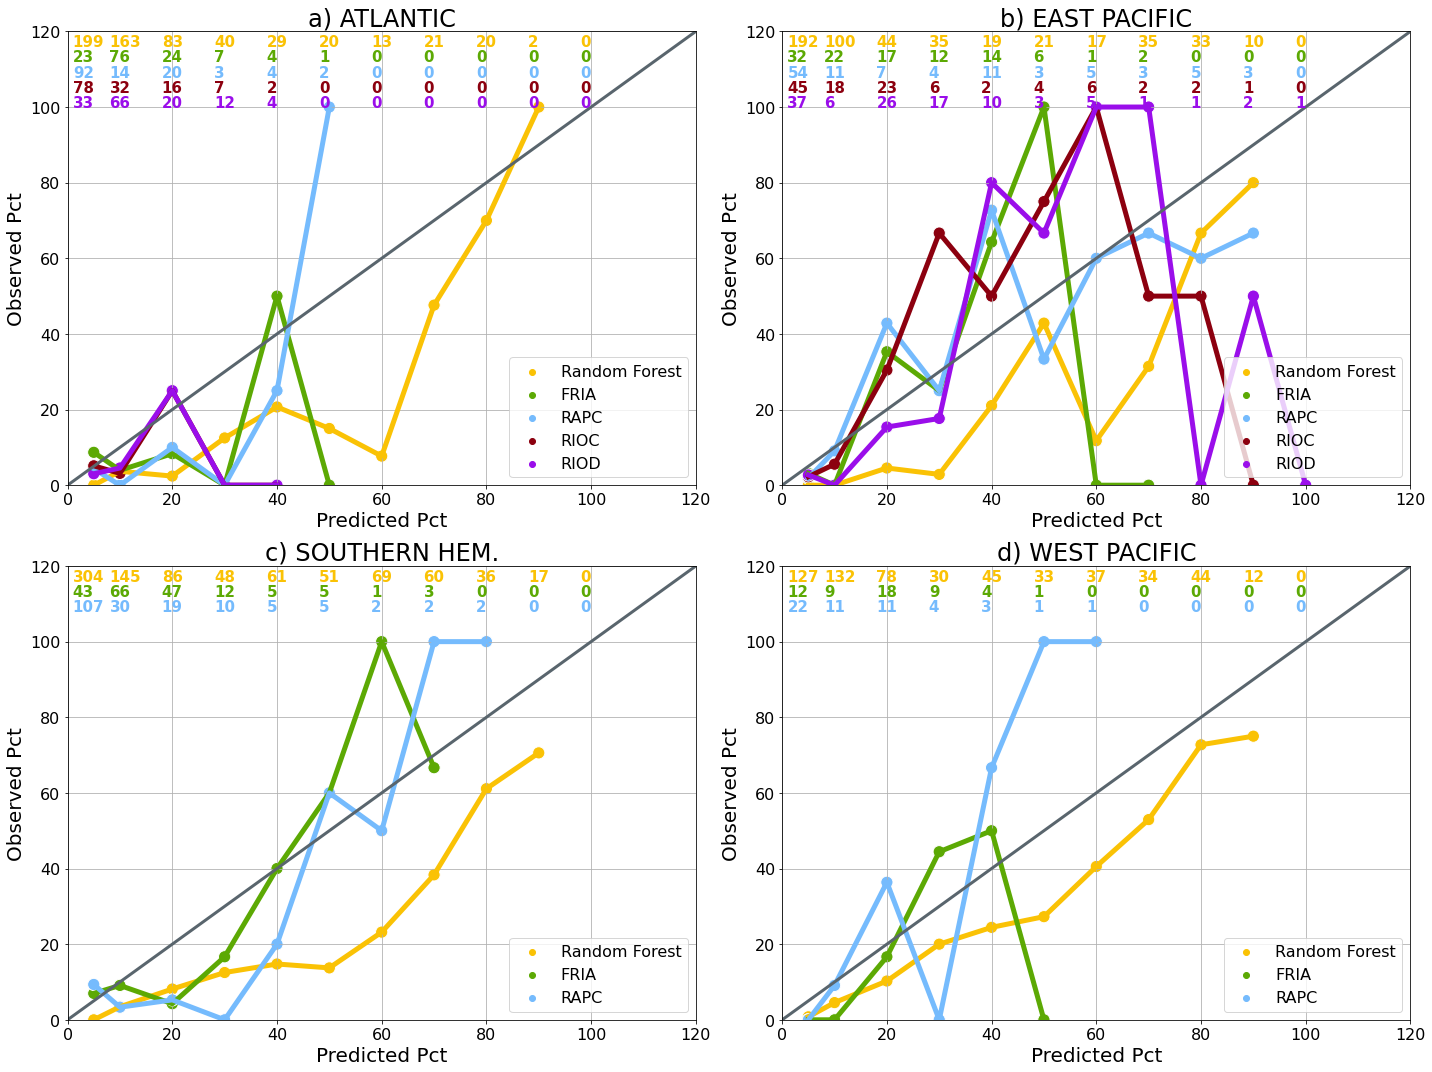

In [11]:
basin_title = {'AL':'ATLANTIC','EP':'EAST PACIFIC','SH':'SOUTHERN HEM.','WP':'WEST PACIFIC'}
lett = ['a)','b)','c)','d)']
palette = {'xkcd:crimson','xkcd:leaf green','xkcd:goldenrod','xkcd:sky blue','xkcd:violet'}
fig1,ax1 = plt.subplots(2,2,figsize=(20,15))
basin_list = reliability_all.index.unique()
for i in np.arange(0,len(basin_list)):
    ax_sel = ax1.flatten()[i]
    ax_sel.grid()
    sns.lineplot(data=reliability_all.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Model',
                ax=ax_sel,legend=False,linewidth=5,palette=sns.set_palette(palette))
    sns.scatterplot(data=reliability_all.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Model',
                   ax=ax_sel,s=150,palette=sns.set_palette(palette))
    ax_sel.plot([0,121.5],[0,121.5],linewidth=3,color='xkcd:slate grey')
    ax_sel.set_xlim([0,120])
    ax_sel.set_ylim([0,120])
    ax_sel.legend(fontsize=16,loc='lower right')
    ax_sel.tick_params(axis='both',labelsize=16)
    ax_sel.set_ylabel('Observed Pct',fontsize=20)
    ax_sel.set_xlabel('Predicted Pct',fontsize=20)
    ax_sel.set_title('{lett} {basin_full}'.format(lett=lett[i],basin_full=basin_title[basin_list[i]]),fontsize=24)
    #
    totals = reliability_all.xs(basin_list[i]).reset_index().sort_values('Predicted Pct').set_index(['Model','Predicted Pct'])
    models_use = reliability_all.xs(basin_list[i])['Model'].unique()
    for n in np.arange(0,len(models_use)):
        mod_sel = totals.xs(models_use[n])
        for i_pct in pct_range:
            if i_pct in mod_sel.index:
                imod = mod_sel.xs(i_pct)['Observed No Total'].astype(int)
            else:
                imod = 0
            yval = 116-(4*n)
            i_color = sns.color_palette()[n]
            ax_sel.text((i_pct-4 if i_pct == 5 else i_pct-2),yval,imod,color=i_color,fontsize=15,weight='semibold')
#
fig1.tight_layout()

##### Explore ML-Cons

In [12]:
RF_con = reliability_all.reset_index().set_index(['Model']).xs('Random Forest').reset_index().sort_values('Predicted Pct')
RF_con = RF_con.set_index(['ATCF BASIN','Predicted Pct'])
#
ML_sel = {'FRIA':['FRIA'],'RIPA_FRIA':['RAPC','FRIA'],'RII_FRIA':['FRIA','RIOD'],'RII_RIPA':['RAPC','RIOD'],
         'SHIPS-RII':['RIOD'],'ALL':['RAPC','FRIA','RIOD']}
ML_con_ALL = pd.DataFrame()
for ikey in list(ML_sel.keys()):
    ML_model_choose = ML_sel[ikey]
    print(ML_model_choose)
    ML_con = reliability_all[reliability_all['Model'].isin(ML_model_choose)].reset_index().sort_values('Predicted Pct')
    ML_con = ML_con.set_index(['ATCF BASIN','Predicted Pct'])
    RF_RII_consensus = pd.concat((RF_con.replace(0,np.nan),ML_con.replace(0,np.nan))).mean(level=(0,1))
    RF_RII_consensus['Name'] = ikey
    ML_con_ALL = ML_con_ALL.append(RF_RII_consensus)

['FRIA']
['RAPC', 'FRIA']
['FRIA', 'RIOD']
['RAPC', 'RIOD']
['RIOD']
['RAPC', 'FRIA', 'RIOD']


In [13]:
ML_con_ALL['Name'].unique()
palette2 = {'xkcd:crimson','xkcd:leaf green','xkcd:goldenrod','xkcd:sky blue','xkcd:violet','xkcd:magenta'}

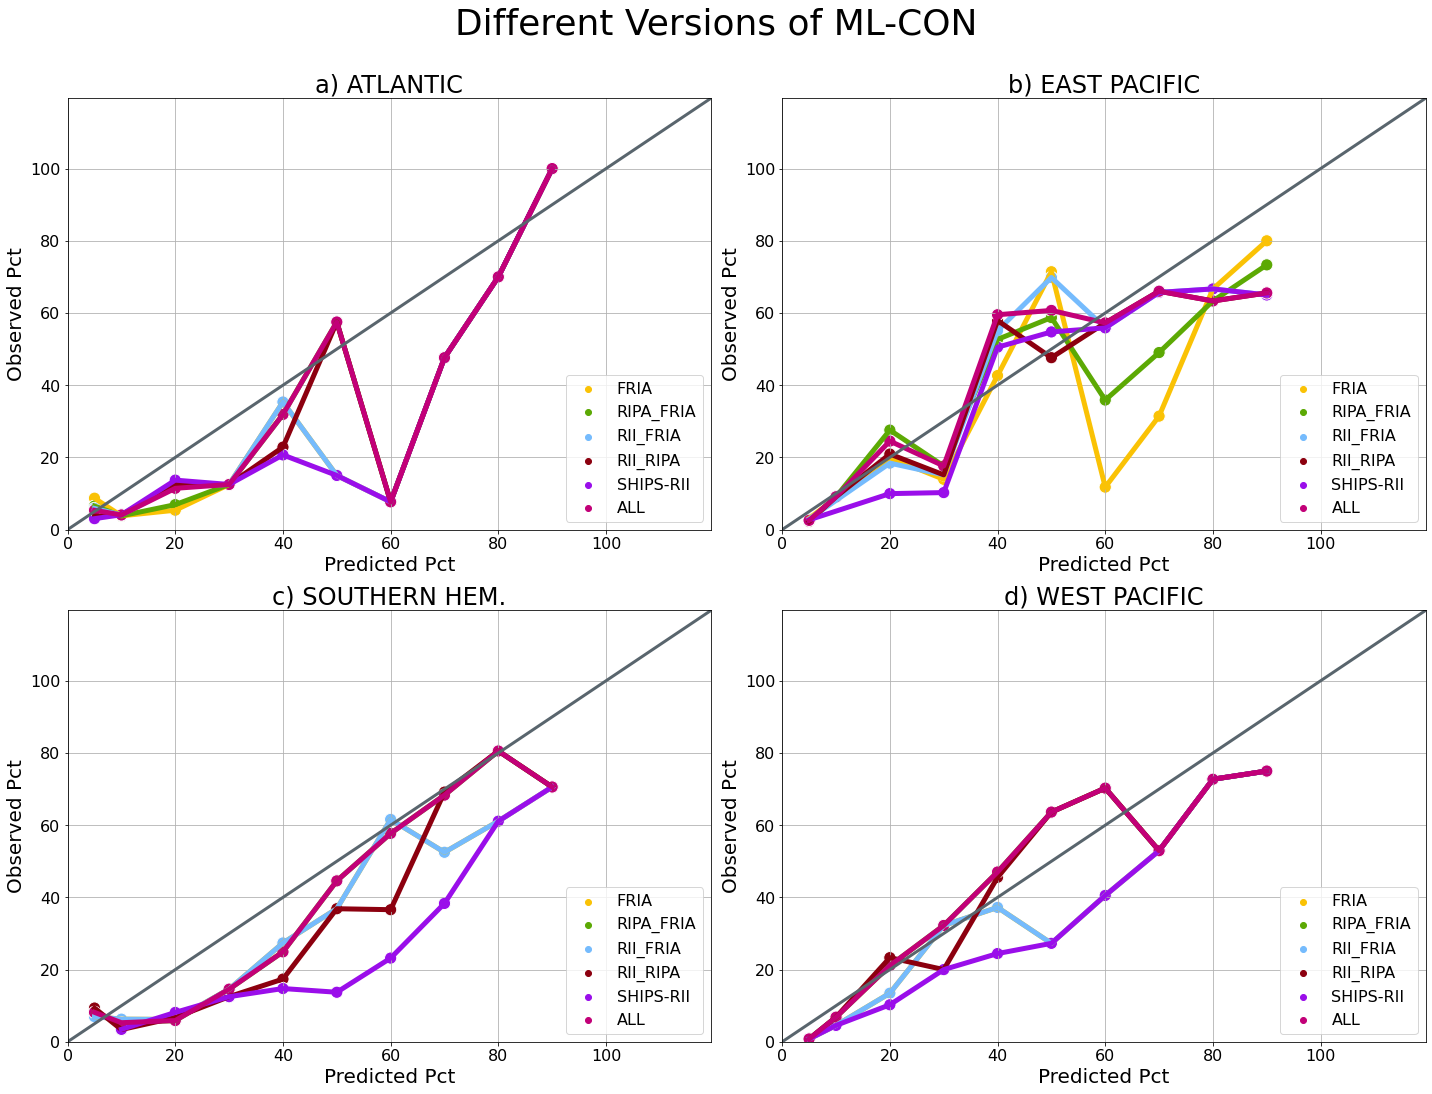

In [14]:
fig2,ax2 = plt.subplots(2,2,figsize=(20,15))
for i in np.arange(0,len(basin_list)):
# i = 0
    ax_sel = ax2.flatten()[i]
    ax_sel.grid()
    sns.lineplot(data=ML_con_ALL.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Name',
                ax=ax_sel,legend=False,linewidth=5,palette=sns.set_palette(palette2))
    sns.scatterplot(data=ML_con_ALL.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Name',
                   ax=ax_sel,s=150,palette=sns.set_palette(palette2))
    ax_sel.plot([0,121.5],[0,121.5],linewidth=3,color='xkcd:slate grey')
    ax_sel.set_xlim([0,119.5])
    ax_sel.set_ylim([0,119.5])
    ax_sel.legend(fontsize=16,loc='lower right')
    ax_sel.tick_params(axis='both',labelsize=16)
    ax_sel.set_ylabel('Observed Pct',fontsize=20)
    ax_sel.set_xlabel('Predicted Pct',fontsize=20)
    ax_sel.set_title('{lett} {basin_full}'.format(lett=lett[i],basin_full=basin_title[basin_list[i]]),fontsize=24)
#
fig2.suptitle('Different Versions of ML-CON',fontsize=36,y=1.01)
fig2.tight_layout()
#
fig2.savefig('Figures/reliability_SHIPS_explore_MLCON_{yr_start}-{yr_end}.png'.format(yr_start=yr_start,yr_end=yr_end),
            format='png',dpi=350,bbox_inches='tight')
fig2.savefig('Figures/reliability_SHIPS_explore_MLCON_{yr_start}-{yr_end}.pdf'.format(yr_start=yr_start,yr_end=yr_end),
            format='pdf',bbox_inches='tight')


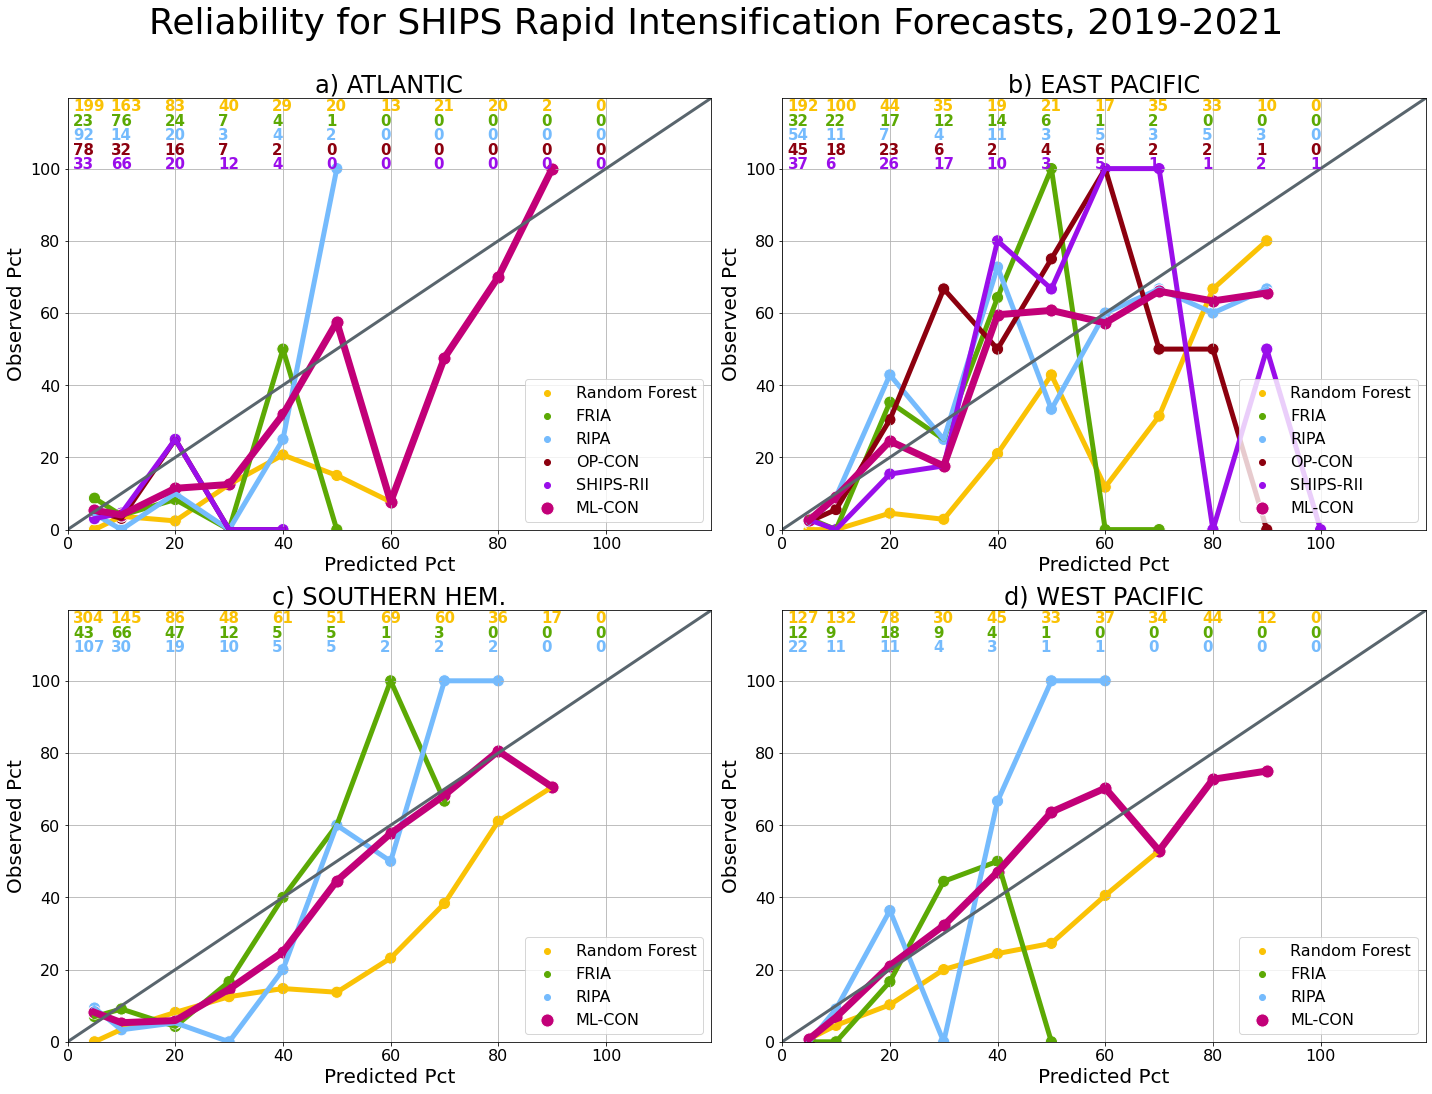

In [15]:
basin_title = {'AL':'ATLANTIC','EP':'EAST PACIFIC','SH':'SOUTHERN HEM.','WP':'WEST PACIFIC'}
ML_con_sel = ML_con_ALL.reset_index().set_index(['Name','ATCF BASIN']).xs('ALL')
lett = ['a)','b)','c)','d)']
palette = {'xkcd:crimson','xkcd:leaf green','xkcd:goldenrod','xkcd:sky blue','xkcd:violet'}
my_cmap = sns.color_palette(palette,as_cmap=True)
fig1,ax1 = plt.subplots(2,2,figsize=(20,15))
basin_list = reliability_all.index.unique()
reliability_all['Model'] = reliability_all['Model'].replace({'RIOC':'OP-CON','RIOD':'SHIPS-RII',
                                                            'RAPC':'RIPA'})
for i in np.arange(0,len(basin_list)):
    ax_sel = ax1.flatten()[i]
    ax_sel.grid()
    sns.lineplot(data=reliability_all.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Model',
                ax=ax_sel,legend=False,linewidth=5,palette=my_cmap)
    sns.scatterplot(data=reliability_all.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Model',
                   ax=ax_sel,s=150,palette=my_cmap)
    # Add ML-CON
    sns.lineplot(data=ML_con_sel.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',
                ax=ax_sel,legend=False,linewidth=7,color='xkcd:magenta')
    sns.scatterplot(data=ML_con_sel.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',
                   ax=ax_sel,s=175,color='xkcd:magenta',label='ML-CON')
    
    ax_sel.plot([0,121.5],[0,121.5],linewidth=3,color='xkcd:slate grey')
    ax_sel.set_xlim([0,119.5])
    ax_sel.set_ylim([0,119.5])
    ax_sel.legend(fontsize=16,loc='lower right')
    ax_sel.tick_params(axis='both',labelsize=16)
    ax_sel.set_ylabel('Observed Pct',fontsize=20)
    ax_sel.set_xlabel('Predicted Pct',fontsize=20)
    ax_sel.set_title('{lett} {basin_full}'.format(lett=lett[i],basin_full=basin_title[basin_list[i]]),fontsize=24)
    #
    totals = reliability_all.xs(basin_list[i]).reset_index().sort_values('Predicted Pct').set_index(['Model','Predicted Pct'])
    models_use = reliability_all.xs(basin_list[i])['Model'].unique()
    for n in np.arange(0,len(models_use)):
        mod_sel = totals.xs(models_use[n])
        for i_pct in pct_range:
            if i_pct in mod_sel.index:
                imod = mod_sel.xs(i_pct)['Observed No Total'].astype(int)
            else:
                imod = 0
            yval = 116-(4*n)
            i_color = sns.color_palette()[n]
            ax_sel.text((i_pct-4 if i_pct == 5 else i_pct-2),yval,imod,color=i_color,fontsize=15,weight='semibold')
#
fig1.suptitle('Reliability for SHIPS Rapid Intensification Forecasts, 2019-2021',fontsize=36,y=1.01)
fig1.tight_layout()
fig1.savefig('Figures/reliability_SHIPS_all_basins_{yr_start}-{yr_end}.png'.format(yr_start=yr_start,yr_end=yr_end),
           format='png',dpi=350,bbox_inches='tight')
fig1.savefig('Figures/reliability_SHIPS_all_basins_{yr_start}-{yr_end}.pdf'.format(yr_start=yr_start,yr_end=yr_end),
            format='pdf',bbox_inches='tight')


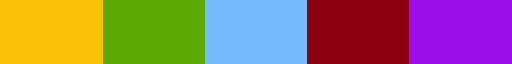

In [16]:
ListedColormap(my_cmap)

### Realtime reliability plot

In [17]:
RF_score = 'gini'
yr_start = 2019
yr_end = 2021
mask = 'SIMPLE_MASK'
stand_str = 'STANDARDIZED'
RI_thresh = 30
weights = 'default'
N_samples_RF = 10
scoring = 'f1_weighted'
RF_dir = 'DATA/ML_model_results/TESTING/REALTIME/all_models_ROS_and_SMOTE/'
#RF_dir = '~/SHIPS/SHIPS_clean/Model_Results/VALIDATION/'
RF_ext = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=yr_start,yr_end=yr_end,mask_TYPE=mask,
            stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,scoring=scoring)
y_pred_RF_RT = pd.read_csv(RF_dir+'PREDICTED_Y_vals'+RF_ext)
# y_pred_RF = y_pred_RF.rename(columns={'I_class':'Y true'})
#y_pred_RF#.groupby(['Predicted Basin','Model',pd.to_datetime(y_pred_RF['DATE_full']).dt.year])['Y pred'].count()

In [18]:
y_pred_res_RT = y_pred_RF_RT.copy()
y_pred_res_RT['Y pred probab (class: 1)'] = y_pred_res_RT['Y pred probab (class: 1)']*100
y_pred_res_RT['Prob. RI'] = (y_pred_res_RT['Y pred probab (class: 1)']).round(-1)
y_pred_res_RT['Prob. RI'] = y_pred_res_RT['Prob. RI'].mask(y_pred_res_RT['Prob. RI'] <= 5, 5)
#

basin_sel = ['ATLANTIC','EAST_PACIFIC','SOUTHERN_HEM','WEST_PACIFIC']

In [19]:
y_trim_RT = y_pred_res_RT[y_pred_res_RT['Predicted Basin'].isin(basin_sel)]
y_trim_RT['YEAR'] = pd.to_datetime(y_trim_RT['DATE_full']).dt.year

/tmp/ipykernel_176508/3785537688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_trim_RT['YEAR'] = pd.to_datetime(y_trim_RT['DATE_full']).dt.year


In [20]:
pct_range = y_trim_RT['Prob. RI'].unique().tolist()
reliability_RT = pd.DataFrame()
for imodel in y_trim_RT['Model'].unique():
    for ipct in pct_range:
        # ipct = 10
        if ipct == 100:
            continue
        y_sel = y_trim_RT.set_index(['Prob. RI','Model']).xs((ipct,imodel))
        total = y_sel.groupby(['Predicted Basin']).count()
        RI = y_sel[y_sel['Y true']==1].groupby(['Predicted Basin']).count()
        i_df = pd.DataFrame(index=total.index,columns={'Observed Pct','Predicted Pct'})
        #
        if len(RI) == 0:
            pct = 0
            i_df['Observed Pct'] = 0
            i_df['Observed No. RI'] = 0
        else:
            pct = 100*(RI/total)
            i_df['Observed Pct'] = pct['CASE']
            i_df['Observed No. RI'] = RI['CASE']
        i_df['Predicted Pct'] = ipct
        i_df['Observed No Total'] = total['CASE']
        i_df['Model'] = imodel
        reliability_RT = reliability_RT.append(i_df)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/mmcgraw/m

In [21]:
reliability_RT['Observed Pct'] = reliability_RT['Observed Pct'].fillna(0)
reliability_RT['Observed No. RI'] = reliability_RT['Observed No. RI'].fillna(0)

In [22]:
reliability_sel_RT = reliability_RT[reliability_RT['Model']==RF_model_choose].reset_index()
reliability_sel_RT['Model'] = reliability_sel_RT['Model'].replace({RF_model_choose:'Random Forest'})
reliability_sel_RT['ATCF BASIN'] = reliability_sel_RT['Predicted Basin']
reliability_sel_RT['ATCF BASIN'] = reliability_sel_RT['ATCF BASIN'].replace({'ATLANTIC':'AL','EAST_PACIFIC':'EP',
                                                        'WEST_PACIFIC':'WP','SOUTHERN_HEM':'SH'})
reliability_all_RT = pd.concat([reliability_sel_RT,reliability_edecks]).set_index(['ATCF BASIN'])

In [23]:
RF_con_RT = reliability_all_RT.reset_index().set_index(['Model']).xs('Random Forest').reset_index().sort_values('Predicted Pct')
RF_con_RT = RF_con_RT.set_index(['ATCF BASIN','Predicted Pct'])
#
ML_sel = {'FRIA':['FRIA'],'RIPA_FRIA':['RAPC','FRIA'],'RII_FRIA':['FRIA','RIOD'],'RII_RIPA':['RAPC','RIOD'],
         'SHIPS-RII':['RIOD'],'ALL':['RAPC','FRIA','RIOD']}
ML_con_ALL_RT = pd.DataFrame()
for ikey in list(ML_sel.keys()):
    ML_model_choose = ML_sel[ikey]
    print(ML_model_choose)
    ML_con = reliability_all_RT[reliability_all_RT['Model'].isin(ML_model_choose)].reset_index().sort_values('Predicted Pct')
    ML_con = ML_con.set_index(['ATCF BASIN','Predicted Pct'])
    RF_RII_consensus_RT = pd.concat((RF_con_RT.replace(0,np.nan),ML_con.replace(0,np.nan))).mean(level=(0,1))
    RF_RII_consensus_RT['Name'] = ikey
    ML_con_ALL_RT = ML_con_ALL_RT.append(RF_RII_consensus_RT)

['FRIA']
['RAPC', 'FRIA']
['FRIA', 'RIOD']
['RAPC', 'RIOD']
['RIOD']
['RAPC', 'FRIA', 'RIOD']


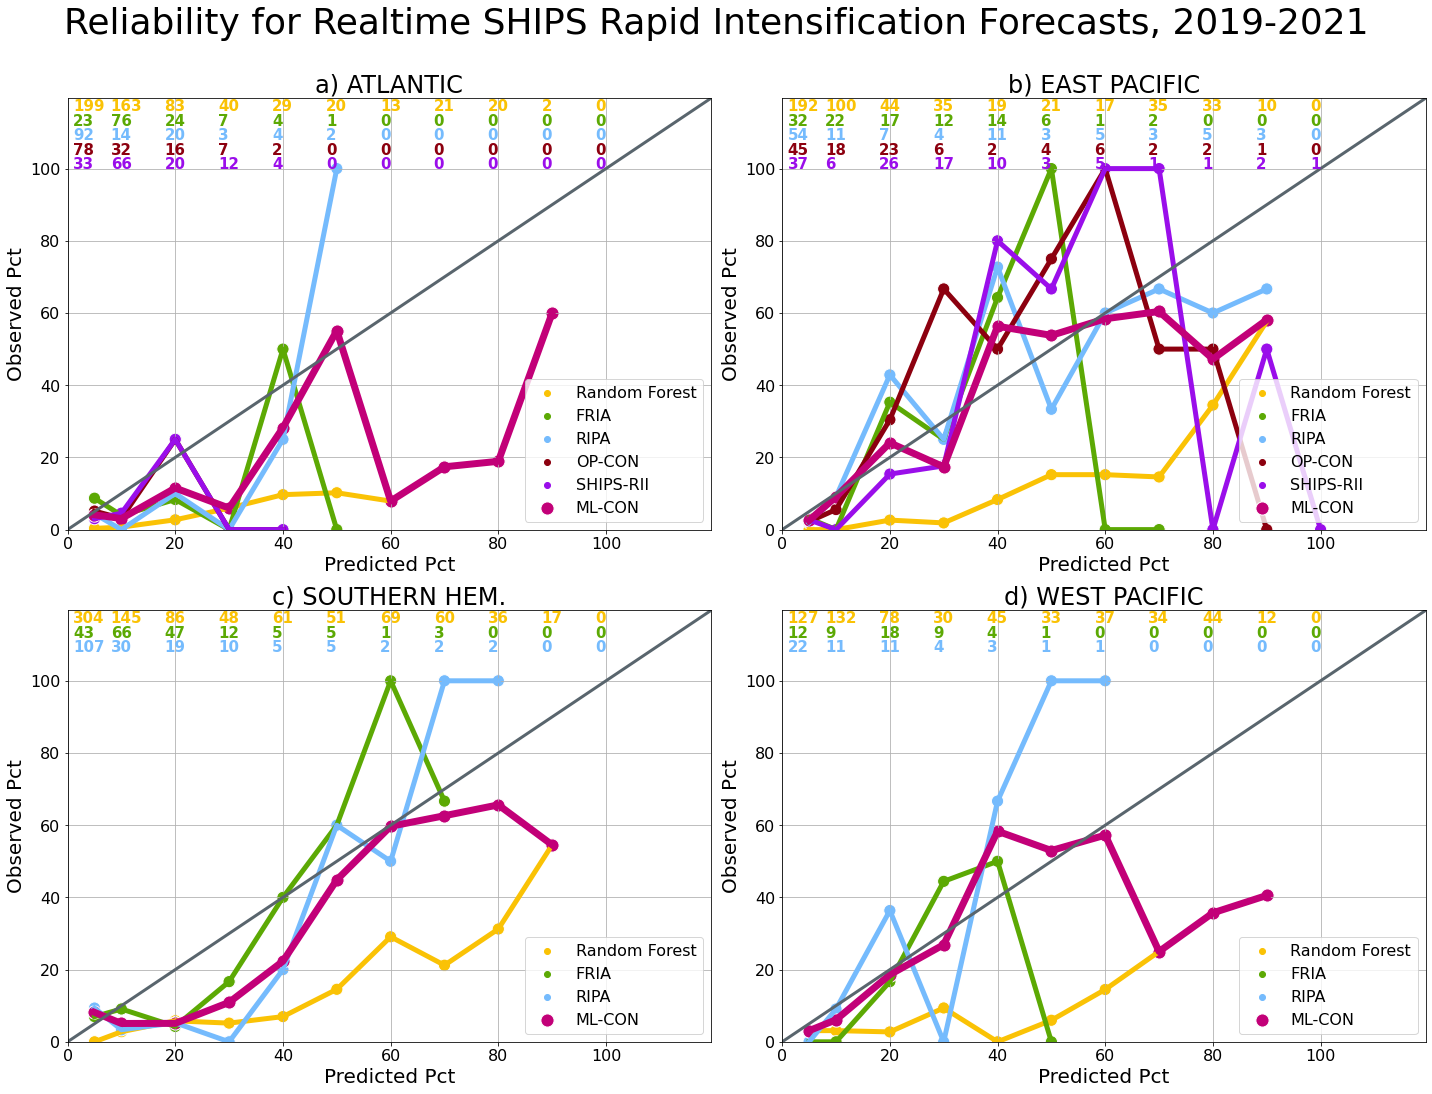

In [24]:
ML_con_sel_RT = ML_con_ALL_RT.reset_index().set_index(['Name','ATCF BASIN']).xs('ALL')
fig1,ax1 = plt.subplots(2,2,figsize=(20,15))
basin_list = reliability_all_RT.index.unique()
reliability_all_RT['Model'] = reliability_all_RT['Model'].replace({'RIOC':'OP-CON','RIOD':'SHIPS-RII',
                                                            'RAPC':'RIPA'})
for i in np.arange(0,len(basin_list)):
    ax_sel = ax1.flatten()[i]
    ax_sel.grid()
    sns.lineplot(data=reliability_all_RT.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Model',
                ax=ax_sel,legend=False,linewidth=5,palette=my_cmap)
    sns.scatterplot(data=reliability_all_RT.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',hue='Model',
                   ax=ax_sel,s=150,palette=my_cmap)
    # Add ML-CON
    sns.lineplot(data=ML_con_sel_RT.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',
                ax=ax_sel,legend=False,linewidth=7,color='xkcd:magenta')
    sns.scatterplot(data=ML_con_sel_RT.xs(basin_list[i]).reset_index(),x='Predicted Pct',y='Observed Pct',
                   ax=ax_sel,s=175,color='xkcd:magenta',label='ML-CON')
    
    ax_sel.plot([0,121.5],[0,121.5],linewidth=3,color='xkcd:slate grey')
    ax_sel.set_xlim([0,119.5])
    ax_sel.set_ylim([0,119.5])
    ax_sel.legend(fontsize=16,loc='lower right')
    ax_sel.tick_params(axis='both',labelsize=16)
    ax_sel.set_ylabel('Observed Pct',fontsize=20)
    ax_sel.set_xlabel('Predicted Pct',fontsize=20)
    ax_sel.set_title('{lett} {basin_full}'.format(lett=lett[i],basin_full=basin_title[basin_list[i]]),fontsize=24)
    #
    totals = reliability_all.xs(basin_list[i]).reset_index().sort_values('Predicted Pct').set_index(['Model','Predicted Pct'])
    models_use = reliability_all_RT.xs(basin_list[i])['Model'].unique()
    for n in np.arange(0,len(models_use)):
        mod_sel = totals.xs(models_use[n])
        for i_pct in pct_range:
            if i_pct in mod_sel.index:
                imod = mod_sel.xs(i_pct)['Observed No Total'].astype(int)
            else:
                imod = 0
            yval = 116-(4*n)
            i_color = sns.color_palette()[n]
            ax_sel.text((i_pct-4 if i_pct == 5 else i_pct-2),yval,imod,color=i_color,fontsize=15,weight='semibold')
#
fig1.suptitle('Reliability for Realtime SHIPS Rapid Intensification Forecasts, 2019-2021',fontsize=36,y=1.01)
fig1.tight_layout()
fig1.savefig('Figures/REALTIME_reliability_SHIPS_all_basins_{yr_start}-{yr_end}.png'.format(yr_start=yr_start,yr_end=yr_end),
            format='png',dpi=350,bbox_inches='tight')
fig1.savefig('Figures/REALTME_reliability_SHIPS_all_basins_{yr_start}-{yr_end}.pdf'.format(yr_start=yr_start,yr_end=yr_end),
            format='pdf',bbox_inches='tight')
